# Plan

- Quick refresh about BN 
- Understand our data
- Packages that support BN in Python 
    + **pgmpy**
    + **pomegrenate**
- Conclusion

# Bayesien Network

In most of the real-life cases when we would be representing or modeling some event, we would be dealing with a lot of random variables. Even if we would consider all the random variables to be discrete, there would still be exponentially large number of values in the joint probability distribution. So, dealing with such huge amount of data would be computationally expensive (even untractable) and require huge amount of memory to store the probability of each combination of states of these random variables.

### Solution ~ Factorization of a distribution over a network

As in most of the cases, many of these variables are marginally or contitionally independent of each other. By exploiting these independencies, we can reduce the number of values we need to store to represent the joint probability distribution.


## What'is a Bayesien Network? 

A Bayesian network is represented by a Directed Acyclic Graph (DAG) and a set of Conditional Probability Distributions (CPD) in which:

    • The nodes represent random variables
    • The edges represent dependencies
    • For each of the nodes, we have a CPD
    

## Why learning the structure of BN can be complicated ?

1. There are difficulties in inferring causality
2. The super-exponential number of directed edges that could exist in a dataset.

## Contexts 

In both libraries, there are a lot of methods, for different contexts.

We have 2 cases: 

1. You know the model and the dependances: Both libraries offer methods to build a model (add nodes and edges) and they check whether the model and all the associated CPDs are consistent.

2. You don't know the model:
    In most real-life problems, we usually have some recorded observations of the variables. Here, we learn to create models using the data we have.

    let's say that the domain is governed by some underlying distribution *P. We are provided with a dataset, D = {d1, d2, ..., dM}, of  M samples. We can assume that these data points have been independently and identically distributed IID sampled from the distribution *P.
    
> Keep in mind that the obtained models obtained are an approximation of the distribution of our data. 
> We need a large amount of data, to be able to construct a network structure with good confidence.

# Data

I applieThe dataset is about heart disease. I didn't choose a dataset about Coronavirus, because i don't want to feel bad.

The _heart.csv_ file contains a set of patients who exhibits cardio-vascular symptoms. There is 17 symptoms/features/variables.

One row in our dataset corresponds to one patient and columns represent a symptom/feature/variable (see table below).

### Attibutes 

Symptom | Definition | Type | Rename 
--------|------------|------|-------
sex     | 1 = male; 0 = female | bool | SEX 
cp      | Chest Pain type | bool | CP
trestbps| Resting blood pressure (in mm Hg on admission to the hospital) | int | TREST_BPS
chol    | Serum Cholestoral in mg/dl | bool | CHOL
fbs     | Fasting Blood Sugar > 120 mg/dl | bool | FBS
restecg | Resting Electrocardio Graphic Results | int | REST_ECG
thalach | maximum heart rate achieved | int | THALACH
exang   | Exercise Induced Angina | bool | ANG 
oldpeak | Depression induced by exercise relative to rest | int | OLD_PEAK
slope   | The Slope of the peak exercise ST segment | int | SLOPE
ca      | Number of major vessels colored by flourosopy | int | CA
thal    | 3 = normal; 6 = fixed defect; 7 = reversable defect | category | THAL
target  | 1 = Sick, else 0 

In [2]:
import warnings
warnings.filterwarnings('ignore') 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from typing import List, Callable

In [3]:
def plot_distribution(attribut: str, qcut: List=[.25, .5, .75]) -> None:
    """

    This function displays the given attribut's distribution

    :param attribut: The colomun's name (feature/variable)
    :param qcut: Discritization values    
    """
    print(f"{attribut} Quantile: \n{df[attribut].quantile(qcut)}")
    
    # nrows, ncols, index
    figure = plt.figure(figsize=(10,4))
    axes1 = figure.add_subplot(131)
    
    if attribut == "AGE":
        grp_age = df.groupby("AGE").size()
        axes1.bar(list(grp_age.index), list(grp_age), width=0.5)
        axes1.set_xticks(np.arange(grp_age.size), list(map(lambda x: str(x), grp_age.index.to_list())))
        axes1.set_title("Group by AGE")
    else:
        # I sorted the values the detect breakpoints
        axes1.plot(sorted(df[attribut]))
        axes1.set_title(attribut)
    
    axes1.set_ylabel('Values')

    axes2 = figure.add_subplot(132) 
    axes2.patch.set_color('lightyellow')
    axes2.set_ylabel(attribut)
    axes2.set_title(f"{attribut} Distribution")
    axes2.boxplot([df[attribut]])
    
    axes3 = figure.add_subplot(133)

    plt.show()

In [25]:
df = pd.read_csv("data/heart.csv").dropna(how="all").drop_duplicates()
# Make sure that there is not duplicated row or Nan row either
df.head(n=2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1


In [26]:
# Know what our dataset is made of
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 14 columns):
age         302 non-null int64
sex         302 non-null int64
cp          302 non-null int64
trestbps    302 non-null int64
chol        302 non-null int64
fbs         302 non-null int64
restecg     302 non-null int64
thalach     302 non-null int64
exang       302 non-null int64
oldpeak     302 non-null float64
slope       302 non-null int64
ca          302 non-null int64
thal        302 non-null int64
target      302 non-null int64
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


In [27]:
# Transform continuous variables into categorical variables
df.rename(columns={"trestbps": "TREST_BPS", "oldpeak": "OLD_PEAK", "restecg":"REST_ECG", "exang":"ANG"}, inplace=True)
df.columns = df.columns.str.strip().str.upper()

Currently, most of the models implemented in Python support discrete bayesian networks, meaning that the values must be categories. So, we have to transform **continuous variables** into **categorical variables**.


In [28]:
df.SEX  = df.SEX.astype(bool) 
df.FBS  = df.FBS.astype(bool)
df.ANG  = df.ANG.astype(bool)

max_string = len(max(df.columns))
for col in df.columns:
    unique = df[col].nunique()
    msg = "--> Must be turned to categorical variable " if unique > 6 else " "
    print(f"Number of distinct value of {col}: {unique:>{max_string - len(col) + 3}} {msg}")

Number of distinct value of AGE:        41 --> Must be turned to categorical variable 
Number of distinct value of SEX:         2  
Number of distinct value of CP:          4  
Number of distinct value of TREST_BPS:  49 --> Must be turned to categorical variable 
Number of distinct value of CHOL:      152 --> Must be turned to categorical variable 
Number of distinct value of FBS:         2  
Number of distinct value of REST_ECG:    3  
Number of distinct value of THALACH:    91 --> Must be turned to categorical variable 
Number of distinct value of ANG:         2  
Number of distinct value of OLD_PEAK:   40 --> Must be turned to categorical variable 
Number of distinct value of SLOPE:       3  
Number of distinct value of CA:          5  
Number of distinct value of THAL:        4  
Number of distinct value of TARGET:      2  


# Continuous Variables into Categorical Variables

AGE Quantile: 
0.25    48.0
0.50    55.5
0.75    61.0
Name: AGE, dtype: float64


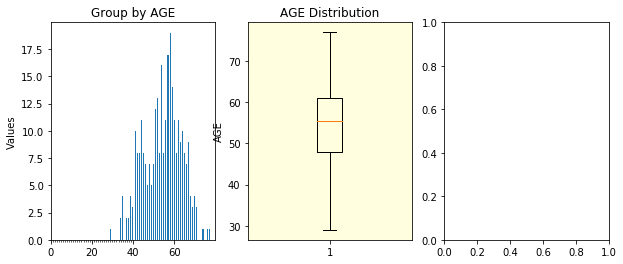

TREST_BPS Quantile: 
0.25    120.0
0.50    130.0
0.75    140.0
Name: TREST_BPS, dtype: float64


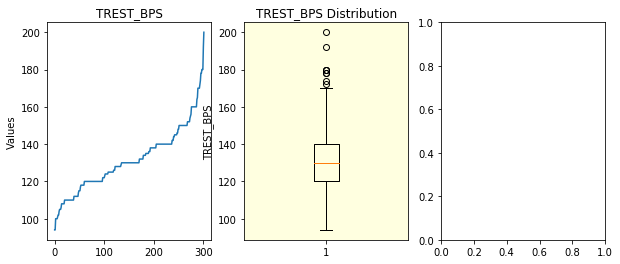

CHOL Quantile: 
0.25    211.00
0.50    240.50
0.75    274.75
Name: CHOL, dtype: float64


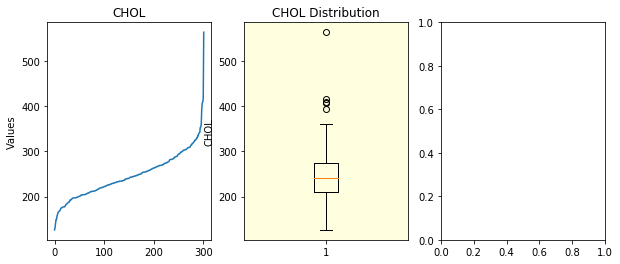

THALACH Quantile: 
0.25    133.25
0.50    152.50
0.75    166.00
Name: THALACH, dtype: float64


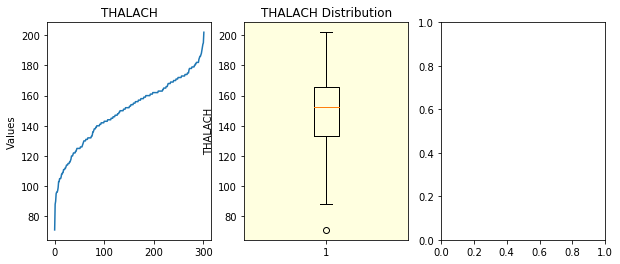

OLD_PEAK Quantile: 
0.25    0.0
0.50    0.8
0.75    1.6
Name: OLD_PEAK, dtype: float64


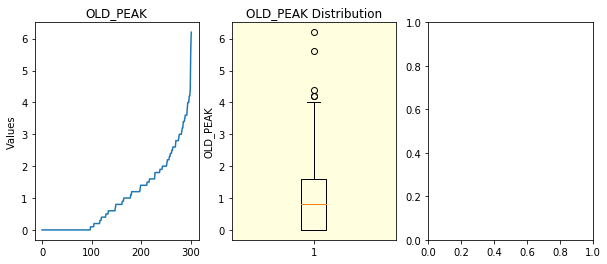

In [29]:
############ AGE ############
plot_distribution(attribut="AGE", qcut=[.25, .5, .75])

df.ix[df.AGE.between(0 ,  45), "AGE"] = 0
df.ix[df.AGE.between(46 , 55), "AGE"] = 1
df.ix[df.AGE.between(56 , 99), "AGE"] = 2
#df.ix[df.AGE.between(70 , 90), "AGE"] = 3

############ REST_BPS ############
plot_distribution(attribut="TREST_BPS", qcut=[.25, .5, .75])

df.ix[df.TREST_BPS <= 120, "TREST_BPS"] = 0         #"Normal"
df.ix[df.TREST_BPS.between(121, 140), "TREST_BPS"] = 1 #"Elevated"
df.ix[df.TREST_BPS.between(141, 300), "TREST_BPS"] = 3 #"Hypertension Crisis"

############ CHOL ############
plot_distribution(attribut="CHOL", qcut=[.25, .5, .75])

df.ix[df.CHOL <= 240, "CHOL"] = 0         #"Normal"
df.ix[df.CHOL.between(241, 260), "CHOL"] = 1 #"Elevated"
df.ix[df.CHOL.between(260, 600), "CHOL"] = 2 #"Hypertension Crisis"

#df.CHOL = df.CHOL.apply(lambda x: 1 if x >= 200 else 0)

########### THALACH ############
plot_distribution(attribut="THALACH", qcut=[.25, .5, .75])

df.ix[df.THALACH <= 50,"THALACH"] = 0
df.ix[df.THALACH.between(51, 65),  "THALACH"] = 1
df.ix[df.THALACH.between(66, 250), "THALACH"] = 2

############ OLD_PEAK ############
plot_distribution(attribut="OLD_PEAK", qcut=[.25, .5, .75])

df.ix[df.OLD_PEAK.between(0.0, .5), "OLD_PEAK"] = 0
df.ix[df.OLD_PEAK.between(.51, 65), "OLD_PEAK"] = 1


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 14 columns):
AGE          302 non-null int64
SEX          302 non-null bool
CP           302 non-null int64
TREST_BPS    302 non-null int64
CHOL         302 non-null int64
FBS          302 non-null bool
REST_ECG     302 non-null int64
THALACH      302 non-null int64
ANG          302 non-null bool
OLD_PEAK     302 non-null float64
SLOPE        302 non-null int64
CA           302 non-null int64
THAL         302 non-null int64
TARGET       302 non-null int64
dtypes: bool(3), float64(1), int64(10)
memory usage: 29.2 KB


# Intuitions and expectations 

I did some research to try to understand the variables in the dataset and the relationships between them.

For example, according to my research, the XXX group should be highly dependent/linked, as these are measurements taken after the stress test. 

I also wanted to see which variables that most influences on the variable _TARGET_ variable. 
I do this with the help of a decision trees.

Before, I have checked if the classes are balanced. One issue to consider !

In [31]:
grp = df.groupby(["TARGET"])
print(grp.size())

TARGET
0    138
1    164
dtype: int64


To avoid bias, we can:

  + Balance the classes by deleting rows (which is a pity, because we information is lost).
  + Choose an apporpiate scroring function which takes into account unbalanced classes.
  
> I have chosen to leave the classes unbalanced and use a scoring function which takes it into account, like f1_score. Because deleting rows, leads to lost information, which is a pity

In [32]:
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [33]:
def plot_feature_importances(clf: Callable) -> None:
    """
    This function displays the importance score of each feature, according to a given classifier "clf"
    
    :param clf: The classifieur 
    :type  clf: DecisionTreeClassifier or GradientBoostingClassifier 
    """
    
    feature_importances = list(clf.feature_importances_)
    plt.barh(np.arange(len(feature_importances)), feature_importances)
    plt.yticks(np.arange(len(feature_importances)), df_train.columns[:-1])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.show()

In [34]:
# Split data into data train and data test

train_0, test_0 = train_test_split(df.query("TARGET == 0"), test_size=0.2)
train_1, test_1 = train_test_split(df.query("TARGET == 1"), test_size=0.2)

df_train = pd.concat([train_0, train_1], ignore_index = True)
df_test  = pd.concat([test_0, test_1],   ignore_index = True)

With one DecisionTreeClassifier
Accuracy on train set: 1.000
Accuracy on test  set:  0.787


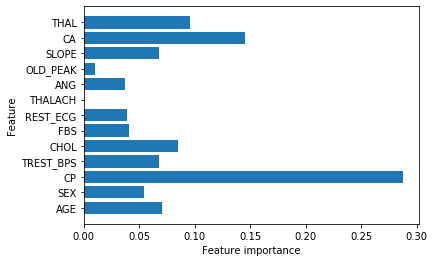

With one GradientBoostingClassifier
Accuracy on train set: 0.866
Accuracy on test  set:  0.954


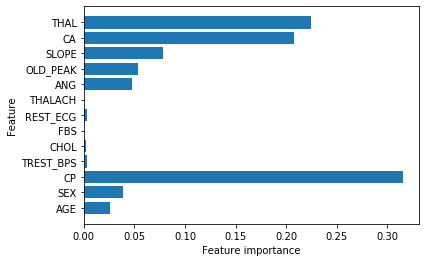

In [35]:
# I first, started with one tree

tree = DecisionTreeClassifier(random_state=727, class_weight="balanced")
tree.fit(df_train.ix[:, 0:-1], df_train.ix[:, -1]) 

train_score = f1_score(y_true=df_train.ix[:, -1], y_pred=tree.predict(df_train.ix[:, 0:-1]))
test_score  = f1_score(y_true=df_test.ix[:, -1],  y_pred=tree.predict(df_test.ix[:, 0:-1]))

print("With one DecisionTreeClassifier")
print(f"Accuracy on train set: {train_score:.3f}")
print(f"Accuracy on test  set: {test_score: .3f}")

plot_feature_importances(clf = tree)

# Then, I tested with GradientBoostingClassifier

gbc = GradientBoostingClassifier(max_depth=1, random_state=727)
gbc.fit(df_train.ix[:, 0:-1], df_train.ix[:, -1])

train_score = f1_score(y_true=df_train.ix[:, -1], y_pred=gbc.predict(df_train.ix[:, 0:-1]))
test_score  = f1_score(y_true=df_test.ix[:, -1],  y_pred=gbc.predict(df_test.ix[:, 0:-1]))

print("With one GradientBoostingClassifier")
print(f"Accuracy on train set: {train_score:.3f}")
print(f"Accuracy on test  set: {test_score: .3f}")

plot_feature_importances(clf = gbc)

# We add a constraint max_depth  = 1
# Otherwise, the score on the training set is 100%, which probably makes us think of overlearning
# To reduce this phenomenon, the complexity of the model is reduced
# A. Either reinforce pre-pruning by limiting the maximum depth of trees (max_depth) ;
# Or
# B. Decrease the value of (learning_state)
# Here we choose a pre-pre-pruning with max_depth, because lr_state only slightly improves generalization performance


**GaussianNB**: naive bayesian classifier, supports continuous variables

In [36]:
clf = GaussianNB()
clf.fit(df_train.ix[:, 0:-1], df_train.ix[:, -1])

train_score = f1_score(y_true=df_train.ix[:, -1], y_pred=clf.predict(df_train.ix[:, 0:-1]))
test_score  = f1_score(y_true=df_test.ix[:, -1],  y_pred=clf.predict(df_test.ix[:, 0:-1]))

print(f"Accuracy on train set: {train_score:.3f}")
print(f"Accuracy on test  set: {test_score:.3f}")

Accuracy on train set: 0.826
Accuracy on test  set: 0.909


## 1. Library pgmpy: 

**pgmpy** is a Python Library for Inference (Causal and Probabilistic) and learning in Bayesian Networks. For more details, see: https://pgmpy.org/, I also attached an interisting book about it in the e-mail.

## Structure learning:

Given a set of data samples, estimate a DAG that captures the dependencies between the variables. There are two broad techniques:
1. score-based structure learning
    This set of methos are similar to search-space with pomegrade. We need 

    There 2 search strategy
    **scoring function**: 
    Computes a score that measures how much a given variable is “influenced” by a given list of potential parents.
    **search strategy**:
    to traverse the search space of possible models and select a model with optimal score
    ExhaustiveSearch: compute the score for every DAG and returns the best-scoring one, as there are many cases, more than 7 variables the calculation is infeasible.
    
    hillClimb: A greedy hill climbing algorithm, an heuristic, which proceeds by step-by-step network modifications until a local maximum is reached. Only estimates network structure, no parametrization.

    There are offers 3 scoring methods:
    + Bayesian Dirichlet scores (BDeu Score)
    + K2 Score
    + Bic Score

2. Constraint-based Structure Learning


A different, but quite straightforward approach to build a DAG from data is this:
- Identify independencies in the data set using hypothesis tests (chi2 conditional independence tests)
- Construct DAG (pattern) according to identified independencies


3. hybrid structure learning (The combination of both previous techniques and HHMM)



### 1.1 Library Bnlearn (graph visualisation):

**Bnlearn** is Python package for learning the graphical structure of Bayesian networks, parameter learning, inference and sampling methods. Bnlearn essentially supports pgmpy. 

***Let's dive in pgmpy***

In [37]:
import bnlearn

from pgmpy.models import BayesianModel
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch, ConstraintBasedEstimator 

Best nodes: 
 ['AGE', 'ANG', 'CA', 'CHOL', 'CP', 'FBS', 'OLD_PEAK', 'REST_ECG', 'SEX', 'SLOPE', 'TARGET', 'THAL', 'THALACH', 'TREST_BPS'] 

Best edges: 
 [('AGE', 'TREST_BPS'), ('CP', 'TARGET'), ('CP', 'ANG'), ('SLOPE', 'OLD_PEAK'), ('THAL', 'SEX'), ('TARGET', 'THAL'), ('TARGET', 'CA'), ('TARGET', 'SLOPE'), ('TARGET', 'AGE'), ('TARGET', 'OLD_PEAK')] 

[BNLEARN][plot] Making plot based on BayesianModel


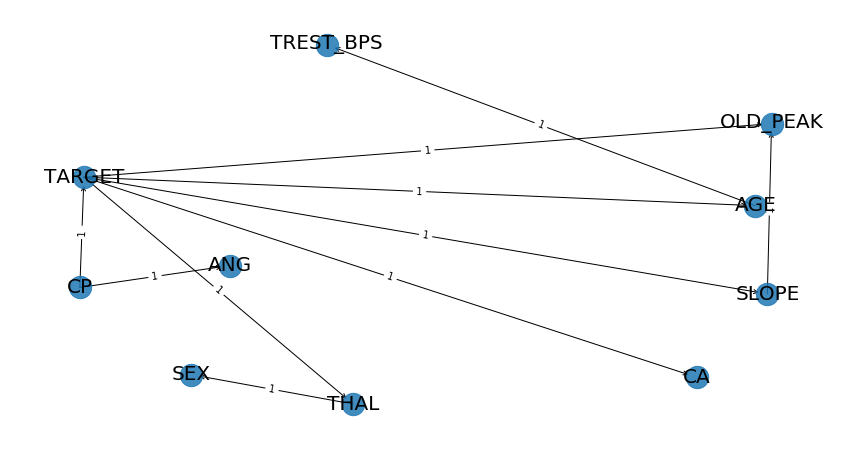

Wall time: 6.15 s


In [38]:
%%time
hcs = HillClimbSearch(df, scoring_method=BicScore(df))
best_model = hcs.estimate(max_indegree=2) # max_indegree=2

print(f"Best nodes: \n {sorted(best_model.nodes())} \n")
print(f"Best edges: \n {best_model.edges()} \n")

G = bnlearn.plot(best_model)

Undirected edges: [('CP', 'ANG'), ('OLD_PEAK', 'SLOPE'), ('CA', 'TARGET'), ('THAL', 'TARGET')]

PDAG edges: [('CP', 'ANG'), ('ANG', 'CP'), ('OLD_PEAK', 'SLOPE'), ('SLOPE', 'OLD_PEAK'), ('CA', 'TARGET'), ('THAL', 'TARGET')]

[BNLEARN][plot] Making plot based on networkx model


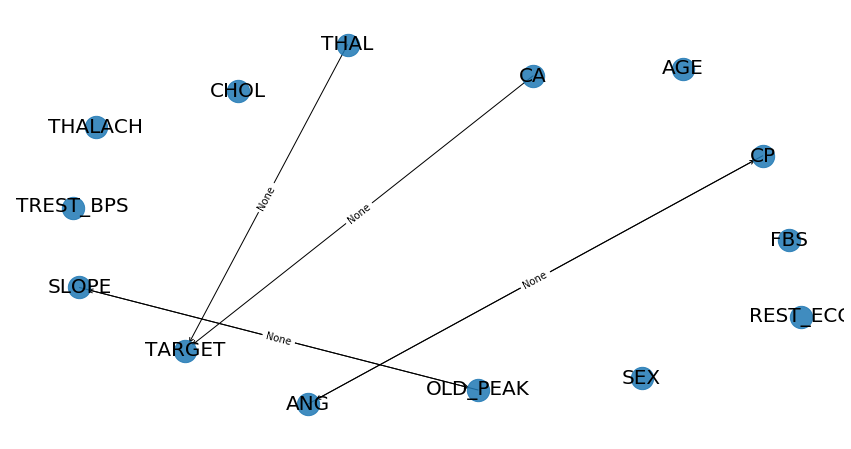

DAG edges: [('ANG', 'CP'), ('SLOPE', 'OLD_PEAK'), ('CA', 'TARGET'), ('THAL', 'TARGET')]

[BNLEARN][plot] Making plot based on BayesianModel


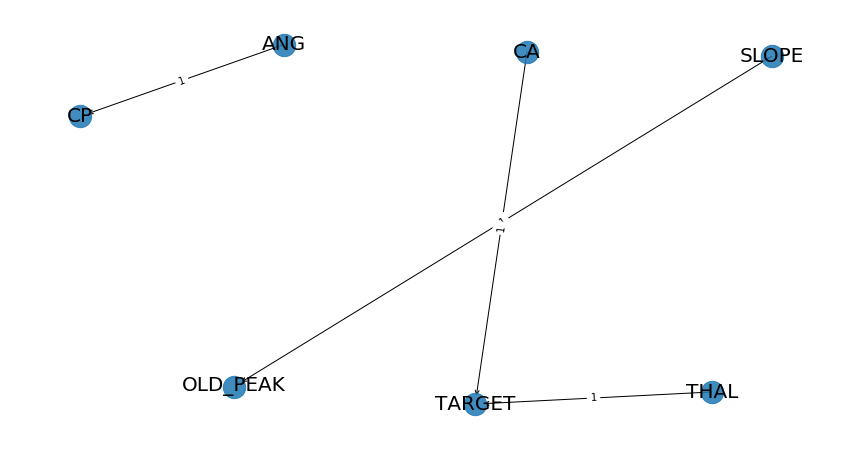

Wall time: 4.39 s


In [39]:
%%time
cbe = ConstraintBasedEstimator(df)
skel, seperating_sets = cbe.estimate_skeleton(significance_level=0.01)
print(f"Undirected edges: {skel.edges()}\n")

pdag = cbe.skeleton_to_pdag(skel, seperating_sets)
print(f"PDAG edges: {pdag.edges()}\n")

G = bnlearn.plot(pdag)

model = cbe.pdag_to_dag(pdag)
print(f"DAG edges: {model.edges()}\n")

G = bnlearn.plot(model)

As, you see, there are il n'y pas beacuoup de dépendances entre les variables 
les graphes sont pas très jolies 
beacup de groupe déconnexté 

# Libraries 

In this projet, i have used 2 libraris, for the BN and 2 libraries for graph visualisation.

## 1. Library pomegranate: 

**pomegranate** 

For more details, see: https://pomegranate.readthedocs.io/

Most methods for Bayesian network structure learning (BNSL) can be put into one of the following categories:

### 1. **Search and Score**: 

Which consists of searching over the space of all possible directed acyclic graphs (DAGs) and identifies the one that minimizes some objective function (which attempt to balance the log probability of the data given the model (the likelihood)). A naive implementation of this search is super-exponential in time with the number of variables, and becomes infeasible when considering more thant 7 variables. However, dynamic programming can efficiently remove the many repeated calculations and reduce this to be simply exponential in time. This allows to scale to ~25-30 variables. 

> Pomegrante utilizes the dynamic programming: shortest path algorithm, A* algorithm, a greedy algorithm based off of DP/A*, and the Chow-Liu tree building algorithm.

#### 1. Algorithm='exact'~ A*:
A* is both computationally faster and requires far less memory.
#### 2. Algorithm='exact-dp'~ shortest path algorithm:
The size of the order graph grows exponentially with the number of variables, and can make tasks infeasible that have otherwise-reasonable computational times. 
#### 3. Algoritjm='greedy' (default)
This simple implementation iteratively finds the best variable to add to the growing topological sort, allowing the new variable to draw only from variables already in the topological sort. This is the default in pomegranate because it has a nice balance between producing good (often optimal) graphs and having a small computational cost and memory footprint. However, there is no guarantee that this produces the globally optimal graph.
#### 4. Algorithm='chow-liu'
It calculates the mutual information between all pairs of variables and then finds the maximum spanning tree. A root node has to be input to turn the undirected edges based on mutual information into directed edges for the Bayesian network. The algorithm is O(d^2)  and practically is extremely fast and memory efficient. Sometimes, it produces bad structures.


### 2. Constraint learning

You have prior information about how groups of nodes are connected to each other and want to exploit that.  
(I had troubles with graph construction, So i did'nt test this one)


### 1.1 Library  (graph visualization):

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks

pyvis interact network visualization

***Let's dive in pomegranate***

In [40]:
import networkx 

from pyvis.network import Network
from pomegranate import BayesianNetwork

In [41]:
# Visualisation

def buil_graph(model: Callable, columns: List, title: str="ex.html") -> None:
    """
    This function display the graph in an html page   
    """
    
    matrix = np.zeros([len(model.structure)] * 2)

    for node, parent_nodes in enumerate(model.structure):
        if len(parent_nodes):
            matrix[node][np.array(list(parent_nodes))] = 1 

    G = networkx.from_numpy_array(matrix, create_using=networkx.DiGraph())
    got_net = Network(height="800px", width="100%", bgcolor="#222222", font_color="white", directed=True, notebook=False)
    got_net.from_nx(networkx.relabel_nodes(G, {i: s for i, s in enumerate(columns)}))
    got_net.show(title)
    
    
def search_and_score(algorithm: str, df: Callable, show: bool=True) -> None:

    print(f"######################## {algorithm} algorithm ########################\n")

    # Structure learning in pomegranate is done using the from_samples method. 
    # You feed it with samples and the algorithm which you'd like to use
    # max_parents 
    model = BayesianNetwork.from_samples(df, algorithm=algorithm)
    # The structure attribute returns a tuple of tuples, 
    # where each inner tuple corresponds to that node (column) in the graph
    # The numbers in that inner tuple correspond to the parents of that node. 
    # Here, node 1 has node 7 as a parent
    print(f"Model strucute: \n{model.structure}")
    print(f"P(D|M) = {model.log_probability(df.to_numpy()).sum()}")
    
    if show:
        buil_graph(model=model, columns=df.columns.to_list(), title=f"{algorithm}.html")

In [42]:
# A*
%time search_and_score(algorithm='exact', df=df, show=True) 

######################## exact algorithm ########################

Model strucute: 
((13,), (7,), (13,), (0,), (), (), (), (4, 5, 6), (2,), (13,), (9, 13), (13,), (1, 7), (7, 12))
P(D|M) = -3047.326593110589
Wall time: 830 ms


![exact](images/exact.png)

In [43]:
# Shortest path algorithm: 
%time search_and_score(algorithm='exact-dp', df=df, show=True)

######################## exact-dp algorithm ########################

Model strucute: 
((13,), (12,), (13,), (0,), (), (), (7,), (), (2,), (10, 13), (13,), (13,), (7,), (7, 12))
P(D|M) = -3047.326593110589
Wall time: 1.4 s


![exact2](images/exact-dp.png)

In [44]:
%time search_and_score(algorithm='greedy', df=df, show=True)

######################## greedy algorithm ########################

Model strucute: 
((13,), (7,), (13,), (0,), (), (7,), (), (), (1, 7), (13,), (9, 13), (13,), (1, 13), (1, 7, 8))
P(D|M) = -3046.427775486064
Wall time: 323 ms


![greedy.png](images/greedy.png)

In [45]:
%time search_and_score(algorithm='chow-liu', df=df, show=True)

######################## chow-liu algorithm ########################

Model strucute: 
((), (12,), (13,), (0,), (6,), (3,), (10,), (0,), (2,), (10,), (13,), (0,), (13,), (11,))
P(D|M) = -3026.656362944183
Wall time: 216 ms


![tchu.png](images/tchu.png)

# Conclusion

- Continuous variables to discrete variables

- Compute time

- HHMMC

- Pomegranate vs PGMpy

-  Documention

## Pomegranate vs Pgmpy

Pomegranate | Pgmpy
------------|---------
is newer    | is older 
More stars  | Fewer stars
Easy to intall | I had to fix manually some errors after installation
Visualization is pleseant | Visualization is not plesant 
Show more dependancies | Show less dependancies 

